In [60]:
import os
import random
import sys

from collections import defaultdict, namedtuple

import matplotlib.pyplot as plt
import pytorch_lightning as pl
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from torchvision import datasets
import torchvision.transforms.v2 as transforms

%matplotlib inline

In [61]:
def seed_everything(seed):
    # фискирует максимум сидов для корректности сравнения разных экспериментов
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(0xBADBEEF)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [62]:
train_transform = transforms.Compose(
    [
        # transforms.RandomRotation(15),
        # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        # transforms.RandomHorizontalFlip(),  # Горизонтальное отражение
        # transforms.RandomErasing(),
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        # transforms.Lambda(lambda x: 1 - x),  # Инверсия цветов (если требуется)
        # transforms.Lambda(lambda x: torch.rot90(x, 1, [1, 2])),
        # transforms.ElasticTransform(alpha=50.0, sigma=8.0),
        # transforms.Normalize((0.2860,), (0.3530,)),  # Нормализация
    ]
)


# Преобразования для тестовых данных
val_transform = transforms.Compose(
    [
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),  # Преобразование в тензор
        # transforms.Lambda(lambda x: 1 - x),
        # transforms.Lambda(lambda x: torch.rot90(x, 1, [1, 2])),
        # transforms.Normalize((0.2860,), (0.3530,)),  # Нормализация
    ]
)
# Train data
f_mnist_train = datasets.FashionMNIST(
    "./data", download=False, transform=train_transform,
)
train_dataloader = DataLoader(
    f_mnist_train, batch_size=128, shuffle=True, num_workers=8
)

# Validation data
f_mnist_val = datasets.FashionMNIST(
    "./data",
    train=False,
    download=False,
    transform=val_transform,
)
val_dataloader = DataLoader(f_mnist_val, batch_size=128, num_workers=8)

In [63]:
idx_to_label = defaultdict(
    None,
    {
        0: "T-shirt/Top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot",
    },
)

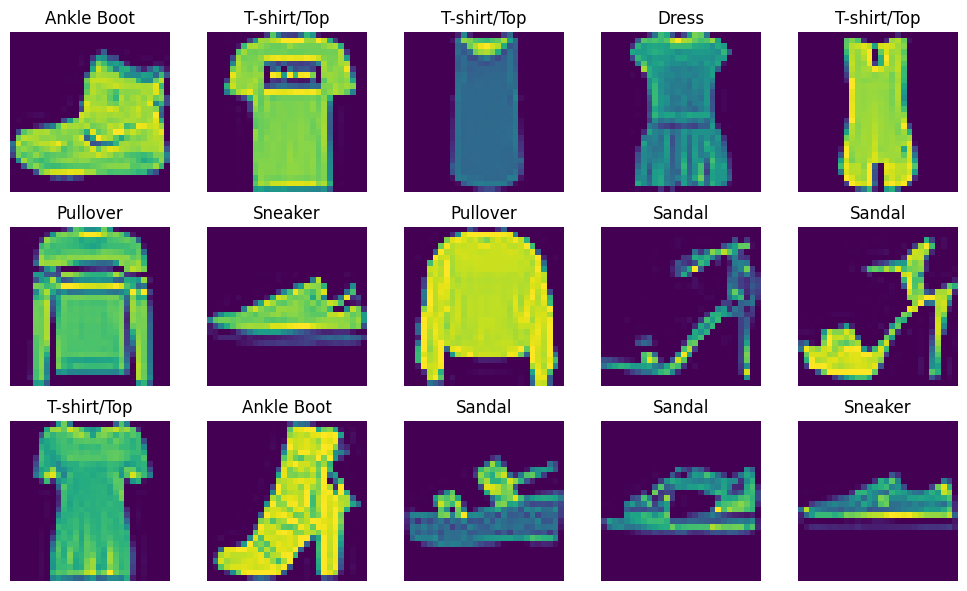

In [64]:
images_train, labels_train = f_mnist_train.data, f_mnist_train.targets

fig, axes = plt.subplots(3, 5, figsize=(10, 6))
axes = axes.ravel()

for i in range(15):
    image = images_train[i].numpy().squeeze()
    axes[i].imshow(image)
    axes[i].set_title(f"{idx_to_label[labels_train[i].item()]}")
    axes[i].axis("off")

plt.tight_layout()
plt.show();


In [65]:
torch.set_float32_matmul_precision('high')

In [66]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchmetrics.functional import accuracy


class SimpleNet(torch.nn.Module):
    def __init__(self, dropout=0.4):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.Conv2d(1, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.conv2 = nn.Sequential(
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # self.conv3 = nn.Sequential(
        #     nn.BatchNorm2d(128),
        #     nn.Conv2d(64, 128, 3),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2),
        # )

        # self.global_pool = nn.AdaptiveAvgPool2d(1)

        self.fc = nn.Sequential(
            nn.Linear(64 * 5 * 5, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            # nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )

        self.targets = None
        self.preds = None

    def _forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # x = self.conv3(x)
        # x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

    def forward(self, images, target=None):
        output = self._forward(images)

        if target is not None:
            loss = F.cross_entropy(output, target, label_smoothing=0.1)

            with torch.no_grad():
                pred = torch.argmax(output, dim=-1)
                self.targets = (
                    torch.cat((self.targets, target.cpu()), 0)
                    if self.targets is not None
                    else target.cpu()
                )
                self.preds = (
                    torch.cat((self.preds, pred.cpu()), 0)
                    if self.preds is not None
                    else pred.cpu()
                )
                self.accuracy = accuracy(
                    self.preds.long(),
                    self.targets.long(),
                    task="multiclass",
                    num_classes=10,
                )

            return loss

        return output

    def get_accuracy(self, reset=False):
        if reset:
            self.targets, self.preds = None, None
        return self.accuracy if hasattr(self, "accuracy") else 0.0

In [67]:
EPOCHS = 10
LR = 0.001

In [68]:
import wandb


class SimpleModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        wandb.init(project="fashion_mnist")

    def forward(self, x):
        result = self.model(x)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        # return optimizer
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=2, factor=0.5)
        # lambda_func = lambda epoch: 0.975**epoch
        # scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_func)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        loss = self.model(images, target)
        # Логируем loss и accuracy в wandb
        acc = self.model.get_accuracy()
        wandb.log({"train_loss": loss.item(), "train_accuracy": acc})

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_accuracy", acc, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        loss = self.model(images, target)
        # Логируем loss и accuracy в wandb
        acc = self.model.get_accuracy()
        wandb.log({"val_loss": loss.item(), "val_accuracy": acc})

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_accuracy", acc, prog_bar=True)

In [69]:
model = SimpleNet().to(device)
module = SimpleModule(model, learning_rate=LR)

# 3) create Trainer and train (±30 seconds on gpu)
trainer = pl.Trainer(accelerator="gpu", max_epochs=10)
trainer.fit(module, train_dataloader, val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | SimpleNet | 232 K  | train
--------------------------------------------
232 K     Trainable params
0         Non-trainable params
232 K     Total params
0.932     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [70]:
print(model.get_accuracy())

tensor(0.9317)
